In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import glob
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import datasets, models 
from tensorflow.keras import layers, activations, initializers
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec

# Hypercomplex-valued dense and conv2d layers:

In [4]:
class HyperDense(layers.Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 algebra = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra
                ):
        super(HyperDense, self).__init__()
        self.units = int(units) if not isinstance(units, int) else units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.algebra = algebra
               

    def build(self, input_shape):
        assert input_shape[-1] % 4 == 0
        input_dim = input_shape[-1] // 4
        
        # Real-part of the weights
        self.kernel_r = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        # Imaginary-part of the weights
        self.kernel_i = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        self.kernel_j = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        self.kernel_k = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        
        # Quaternion-valued bias
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(4*self.units,), initializer="zeros", trainable=True
                )
        else:
            self.bias = None

    def call(self, inputs):
        W_r = tf.concat([self.kernel_r,self.algebra[0,0]*self.kernel_i,self.algebra[1,1]*self.kernel_j,self.algebra[2,2]*self.kernel_k],axis=0)
        W_i = tf.concat([self.kernel_i,self.kernel_r,self.algebra[1,2]*self.kernel_k,self.algebra[2,1]*self.kernel_j],axis=0)
        W_j = tf.concat([self.kernel_j,self.algebra[0,2]*self.kernel_k,self.kernel_r,self.algebra[2,0]*self.kernel_i],axis=0)
        W_k = tf.concat([self.kernel_k,self.algebra[0,1]*self.kernel_j,self.algebra[1,0]*self.kernel_i,self.kernel_r],axis=0)
        W = tf.concat([W_r,W_i,W_j,W_k],axis=1)
        outputs = tf.matmul(inputs, W)
        
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)
        
        return outputs

In [5]:
class HyperConv2D(layers.Layer):
    def __init__(self, 
                 filters, 
                 kernel_size, 
                 strides=1, 
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None,
                 algebra = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra
                ):
        super(HyperConv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.initializer = initializers.get(initializer)
        self.data_format = data_format
        self.algebra = algebra
        
    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('HyperConv2d is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1
    
    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % 4 != 0:
            raise ValueError('The number of input channels must be divisible by 4.')
    
        input_dim = input_channel // 4
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        self.kernel_r = self.add_weight(
            name='real_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_i = self.add_weight(
            name='imag_i_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_j = self.add_weight(
            name='imag_j_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_k = self.add_weight(
            name='imag_k_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        
        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(4*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):        
        # Filter multiplied from the right!
        F_r = tf.concat([self.kernel_r,self.algebra[0,0]*self.kernel_i,self.algebra[1,1]*self.kernel_j,self.algebra[2,2]*self.kernel_k],axis=2)
        F_i = tf.concat([self.kernel_i,self.kernel_r,self.algebra[1,2]*self.kernel_k,self.algebra[2,1]*self.kernel_j],axis=2)
        F_j = tf.concat([self.kernel_j,self.algebra[0,2]*self.kernel_k,self.kernel_r,self.algebra[2,0]*self.kernel_i],axis=2)
        F_k = tf.concat([self.kernel_k,self.algebra[0,1]*self.kernel_j,self.algebra[1,0]*self.kernel_i,self.kernel_r],axis=2)
               
        y_r = tf.nn.conv2d(inputs, F_r, strides=self.strides, padding=self.padding)
        y_i = tf.nn.conv2d(inputs, F_i, strides=self.strides, padding=self.padding)
        y_j = tf.nn.conv2d(inputs, F_j, strides=self.strides, padding=self.padding)
        y_k = tf.nn.conv2d(inputs, F_k, strides=self.strides, padding=self.padding)
        
        outputs = tf.concat([y_r, y_i, y_j, y_k],axis=3)
        
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)
            
        if self.activation is not None:
            outputs = self.activation(outputs)
        
        return outputs

# Load the dataset using RGB and HSV encodings:

In [6]:
image_size = (100,100)
dataset_path = "/content/gdrive/MyDrive/Datasets/ALL_IDB/ALL_IDB2/img/*.tif"

imgs_list = [f for f in glob.glob(dataset_path)]
N = len(imgs_list)
print("Number of images:",N)

Xr_rgb = np.zeros((N,image_size[0],image_size[1],3))
Xq_rgb = np.zeros((N,image_size[0],image_size[1],4))
Xr_hsv = np.zeros((N,image_size[0],image_size[1],3))
Xq_hsv = np.zeros((N,image_size[0],image_size[1],4))
y = np.zeros((N,))

z = np.zeros((image_size[0],image_size[1],1))
for i,img_path in enumerate(imgs_list):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, image_size)

    # RGB images
    Xr_rgb[i,:,:,:] = img_resized/255
    Xq_rgb[i,:,:,:] = np.concatenate([z,img_resized/255],axis=2)
    
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    H = np.reshape((2*np.pi/180)*img_hsv[:,:,0],(image_size[0],image_size[1],1))
    S = np.reshape(img_hsv[:,:,1]/255,(image_size[0],image_size[1],1))
    V = np.reshape(img_hsv[:,:,2]/255,(image_size[0],image_size[1],1))
    
    # Real-valued images;
    Xr_hsv[i,:,:,:] = np.concatenate([H,S,V],axis=2)

    # Quaternion-valued images obtained using HSV;
    Xq_hsv[i,:,:,:] = np.concatenate([np.cos(H)*S,np.sin(H)*S,np.cos(H)*V,np.sin(H)*V],axis=2)
    
    ind = img_path.find(".tif")
    y[i] = int(img_path[ind-1])
    
print("Number of lymphoblasts:",int(np.sum(y)))

Number of images: 260
Number of lymphoblasts: 130


## Show a sample image

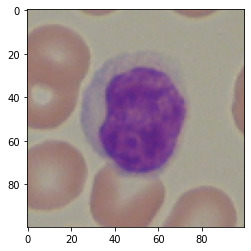

In [7]:
plt.imshow(Xr_rgb[3,:,:,:])

# Partitionate the dataset

In [11]:
indtr, indte, ytr, yte = train_test_split(range(260), y, test_size=0.5)

# Evaluate a real-valued network with RGB encoding

Select RGB images for train and test:

In [12]:
Xtr = Xr_rgb[indtr]
Xte = Xr_rgb[indte]

Construc and train the RGB real-valued network:

In [13]:
tf.keras.backend.clear_session()
       
datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_real = kr.Sequential(
    [
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None)
    ]
)

model_real.compile(optimizer='adam',
      loss=kr.losses.BinaryCrossentropy(from_logits=True),
      metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_real.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=100, verbose=0)
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_real.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_real.predict(Xte).flatten()>=0)

print("Real-valued Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Real-valued Accuracy (Train/Test) = 1.00/0.98 -- Time: 14.211(s).


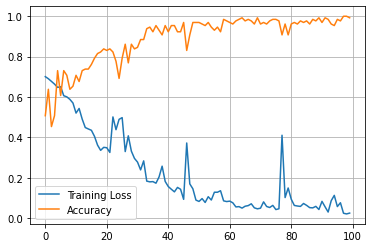

In [14]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

# Evaluate a Quaternion-valued Network with HSV encoding

Select 4D-HSV images for train and test:

In [15]:
Xtr = Xq_hsv[indtr]
Xte = Xq_hsv[indte]

Construc and train the HSV quaternion-valued network:

In [16]:
tf.keras.backend.clear_session()

quaternions = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

H_algebra = tf.Variable((3,3))
model_hyper = kr.Sequential(
    [
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(32, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=100, verbose=0)
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

print("Quaternion-valued Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Quaternion-valued Accuracy (Train/Test) = 1.00/0.98 -- Time: 22.973(s).


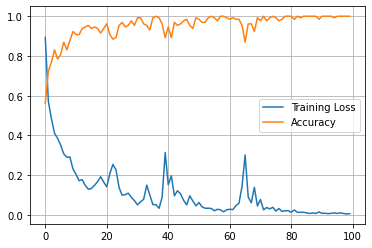

In [17]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

# Evaluate a coquaternion-valued Network with HSV encoding

We use the same partition used in the HSV quaternion-valued network.

In [18]:
tf.keras.backend.clear_session()

coquaternions = np.array([[-1,+1,-1],[-1,+1,-1],[1,1,1]]) # Coquaternion algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

H_algebra = tf.Variable((3,3))
model_hyper = kr.Sequential(
    [
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = coquaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = coquaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(32, kernel_size=(3, 3), activation="relu", algebra = coquaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=100, verbose=0)
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

print("Coquaternion-valued Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Coquaternion-valued Accuracy (Train/Test) = 1.00/0.98 -- Time: 22.827(s).


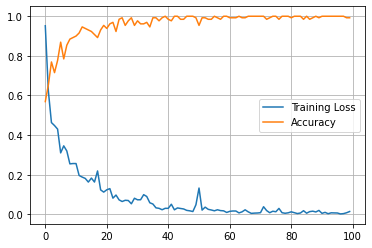

In [19]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()